In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
x_train = pd.read_csv('/home/rashmi/BE Project/pre-processed/s2e/audio_train.csv')
x_test = pd.read_csv('/home/rashmi/BE Project/pre-processed/s2e/audio_test.csv')

print(x_train.shape)
y_train = x_train['label'] # only lable column is saved 
y_test = x_test['label'] # only lable column is saved 


(1704, 10)


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(1704, 10) (426, 10)
{2: 508, 1: 357, 5: 297, 3: 242, 4: 165, 0: 135}


In [4]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)
svc_classifier = LinearSVC()
mnb_classifier = MultinomialNB()
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)


Test Set Accuracy =  0.563
Test Set F-score =  0.588
Test Set Precision =  0.642
Test Set Recall =  0.586
Confusion matrix, without normalization
[[ 9 14  9  1  0  2]
 [ 3 32 41  0  0  9]
 [ 3 26 81  0  0  8]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 15 54  1  0 17]]


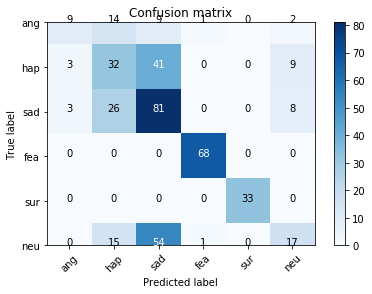

In [6]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('xgb', xgb_classifier), ('mnb', mnb_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

with open('pre-processed/pred_probas/ensemble_wo_mfcc.pkl', 'wb') as f:
    pickle.dump(eclf1, f)

Test Set Accuracy =  0.547
Test Set F-score =  0.583
Test Set Precision =  0.609
Test Set Recall =  0.582
Confusion matrix, without normalization
[[10 16  6  1  0  2]
 [ 4 31 37  0  0 13]
 [ 5 32 68  2  1 10]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 1 15 47  1  0 23]]


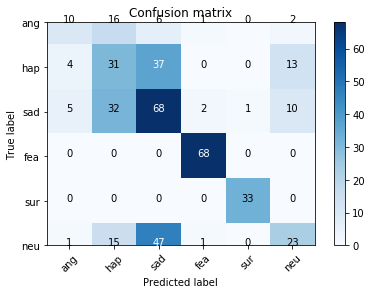

In [14]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('xgb', xgb_classifier), ('mlp', mlp_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


Test Set Accuracy =  0.559
Test Set F-score =  0.593
Test Set Precision =  0.635
Test Set Recall =  0.590
Confusion matrix, without normalization
[[11 15  7  0  0  2]
 [ 4 33 40  0  0  8]
 [ 5 29 76  0  0  8]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 14 55  1  0 17]]


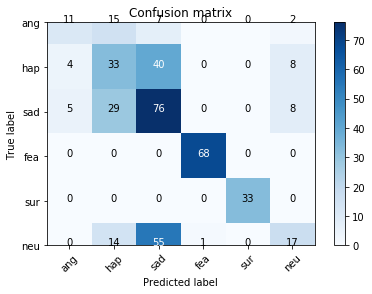

In [15]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('xgb', xgb_classifier), ('lr', lr_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)

Test Set Accuracy =  0.549
Test Set F-score =  0.557
Test Set Precision =  0.633
Test Set Recall =  0.570
Confusion matrix, without normalization
[[ 8 12 13  1  0  1]
 [ 3 29 45  1  0  7]
 [ 0 25 84  2  2  5]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 13 57  3  2 12]]


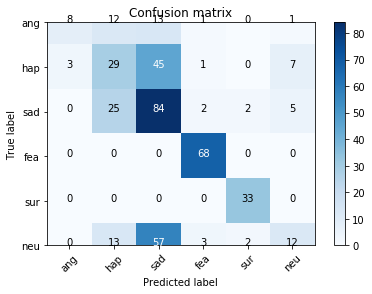

In [16]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('mnb', mnb_classifier), ('mlp', mlp_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


Test Set Accuracy =  0.549
Test Set F-score =  0.543
Test Set Precision =  0.647
Test Set Recall =  0.559
Confusion matrix, without normalization
[[ 7 12 15  0  0  1]
 [ 3 22 56  0  0  4]
 [ 0 17 99  0  0  2]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0  8 73  1  0  5]]


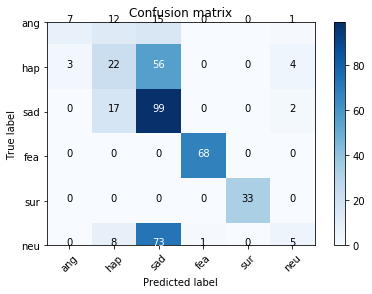

In [18]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('mnb', mnb_classifier), ('lr', lr_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


Test Set Accuracy =  0.542
Test Set F-score =  0.559
Test Set Precision =  0.616
Test Set Recall =  0.567
Confusion matrix, without normalization
[[ 7 13 12  1  0  2]
 [ 3 30 36  1  1 14]
 [ 0 32 73  2  2  9]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 14 49  2  2 20]]


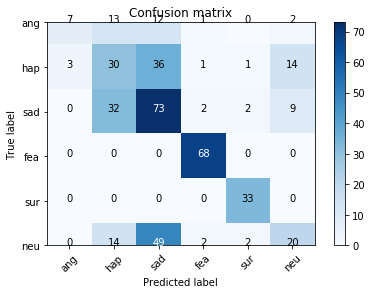

In [19]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('mlp', mlp_classifier), ('lr', lr_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


Test Set Accuracy =  0.563
Test Set F-score =  0.580
Test Set Precision =  0.640
Test Set Recall =  0.582
Confusion matrix, without normalization
[[ 8 10 14  1  0  2]
 [ 3 31 43  0  0  8]
 [ 3 23 84  2  0  6]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 11 58  2  0 16]]


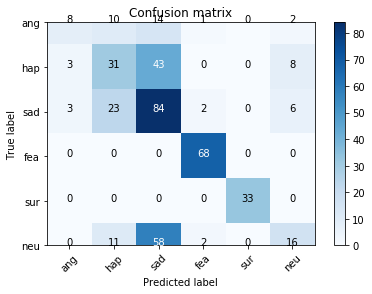

In [20]:
eclf1 = VotingClassifier(estimators=[('xgb', xgb_classifier), ('mnb', mnb_classifier), ('mlp', mlp_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


Test Set Accuracy =  0.554
Test Set F-score =  0.567
Test Set Precision =  0.637
Test Set Recall =  0.574
Confusion matrix, without normalization
[[ 9 13 10  1  0  2]
 [ 2 29 48  0  0  6]
 [ 3 22 89  0  0  4]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 10 68  1  0  8]]


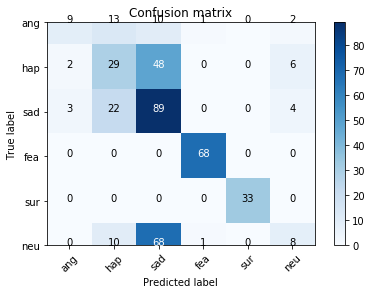

In [21]:
eclf1 = VotingClassifier(estimators=[('lr', lr_classifier), ('xgb', xgb_classifier), ('mnb', mnb_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


Test Set Accuracy =  0.552
Test Set F-score =  0.576
Test Set Precision =  0.628
Test Set Recall =  0.577
Confusion matrix, without normalization
[[ 9 13 11  0  0  2]
 [ 2 34 42  0  0  7]
 [ 5 27 79  0  0  7]
 [ 0  0  0 68  0  0]
 [ 0  0  0  0 33  0]
 [ 0 17 57  1  0 12]]


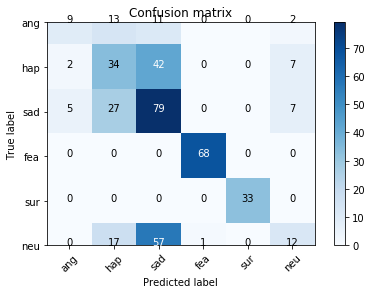

In [22]:
eclf1 = VotingClassifier(estimators=[('lr', lr_classifier), ('xgb', xgb_classifier), ('mlp', mlp_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


Test Set Accuracy =  0.378
Test Set F-score =  0.269
Test Set Precision =  0.442
Test Set Recall =  0.292
Confusion matrix, without normalization
[[  7  10  17   1   0   0]
 [  3  14  65   2   0   1]
 [  0   9 107   2   0   0]
 [  0   0  36  32   0   0]
 [  0   0  32   1   0   0]
 [  0   3  78   5   0   1]]


/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rashmi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


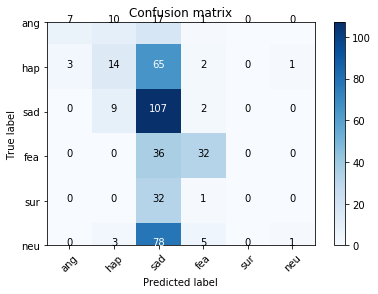

In [23]:
eclf1 = VotingClassifier(estimators=[('lr', lr_classifier), ('mlp', mlp_classifier), ('mnb', mnb_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


In [24]:
eclf1 = VotingClassifier(estimators=[('rf', rf_classifier), ('svc', svc_classifier), ('mnb', mnb_classifier)], voting='soft')
eclf1 = eclf1.fit(x_train, y_train)
pred_probs=eclf1.predict_proba(x_test)
display_results(y_test, pred_probs)


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'